This project aims at exploring machine learning abilities to predict values, classify and cluster groups using the NY taxi dataset. The project will build a model that can predict the travel time (in seconds) for a taxi trip based on pickup/dropoff points, passenger count, and timestamps. Later, the project implement a model that can classify which taxi vendor (vendor_id) performed the trip, based on geographical data and trip characteristics. Thus, we implmemnt regression and classification models.   
We will prepare the data to be used with several machine learning algorithms/models such as regression analysis, SVT, Decision tree and Neural networks.    
We will predict the travel time between the start and end points. We will also try to classify the trips according to the vendor of the taxi.   
We will later evalute the results of the different ML models.


Data describtion:
The NY taxi data was originally published by the NYC Taxi and Limousine Commission. The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

Data is downloaded from this link as a CSV file https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration/data


Initial Row Count

Approximately 1.45 million rows.

**Column Definitions:**  
id: Unique identifier for each trip.
vendor_id: Code indicating the taxi company providing the trip.  
pickup_datetime: The date and time when the trip began.  
dropoff_datetime: The date and time when the trip ended (used only in training).  
passenger_count: Number of passengers in the vehicle, as entered by the driver.  
pickup_longitude: Longitude of the trip's starting point.  
pickup_latitude: Latitude of the trip's starting point.  
dropoff_longitude: Longitude of the trip's ending point.  
dropoff_latitude: Latitude of the trip's ending point.  
store_and_fwd_flag: Indicates whether the trip data was temporarily stored in the vehicle before being sent (Y = Yes, N = No).   
trip_duration: The duration of the trip in seconds (target variable).

# **Package preparation**

In [1]:
!pip install geopandas pandas numpy matplotlib seaborn contextily scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 63.2 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import warnings
from math import radians, sin, cos, sqrt, asin
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
import tensorflow as tf
import os
from tensorflow.keras import layers
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
import holidays

In [4]:
#Silence non-critical warnings that often clutter the notebook output, making the results easier to read.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

# Reading the data

In [5]:
# reading the file from my google drive or from the source in campus
#CSV_file= pd.read_csv('/content/NYC_trip.csv')
#drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/Taxi_proj'
FILE_PATH = f"{DRIVE_PATH}/NYC_trip.csv"

DF_file= pd.read_csv(FILE_PATH)
init_rows, init_cols = DF_file.shape
print(f'the dimension of this dataset is {DF_file.shape}')

the dimension of this dataset is (1458644, 11)


In [6]:
DF_file.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


# **Exploring the dataset**

# Visualizing the pickup locations

In [7]:
# creating a geodataframe to visuzlie the points
#combining longitude and latitude into Point objects
geometry = [Point(xy) for xy in zip(DF_file['pickup_longitude'], DF_file['pickup_latitude'])]
gdf = gpd.GeoDataFrame(DF_file.copy(), geometry=geometry, crs='EPSG:4326')

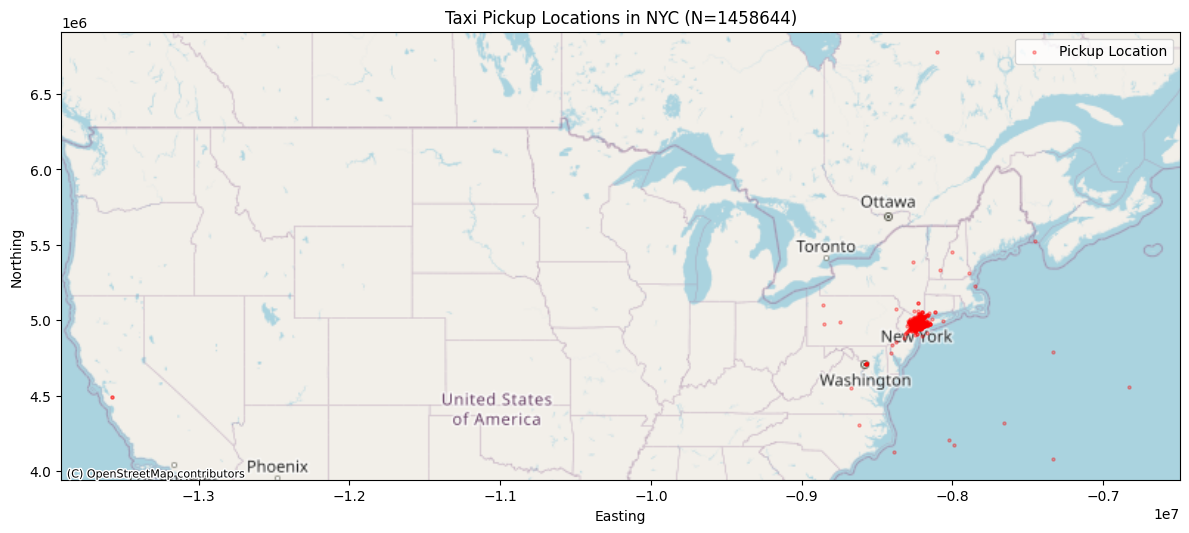

In [8]:

# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()


**There is a problem with points that are outside NY city**  
we will handle this later in the data cleaning section.

In [9]:
DF_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [10]:
# check null values
DF_file.isnull().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


No nulls. that is good!

# **Feature engineering and data cleaning**

**Find out the distance between start and end points**

In [11]:

# calculte the straight line distance in KM between the pickup and dropoff points
# the coordinates are represented in WGS 84
# the coordinate is geodiosic meaning that they are shown in decimal degrees
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points
    using the Haversine formula.Returns the distance in kilometers.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2

    # Earth's radius in kilometers
    R = 6371

    # Calculate the distance
    c = 2 * asin(sqrt(a))
    km = R * c
    return km

try:
    #Extract the coordinate arrays
    pickup_lon = DF_file['pickup_longitude'].values
    pickup_lat = DF_file['pickup_latitude'].values
    dropoff_lon = DF_file['dropoff_longitude'].values
    dropoff_lat = DF_file['dropoff_latitude'].values

    # Vectorize the Haversine function for performance
    vectorized_haversine = np.vectorize(haversine)

    # Apply the vectorized function and create the new column
    DF_file['Distance_KM'] = vectorized_haversine(
        pickup_lon, pickup_lat, dropoff_lon, dropoff_lat
    )

    print(DF_file['Distance_KM'].head())

except KeyError as e:
    print(f"Error: Missing column in DF_file. {e}")
except Exception as e:
    print(f"An unexpected error occurred during calculation: {e}")


0    1.498521
1    1.805507
2    6.385098
3    1.485498
4    1.188588
Name: Distance_KM, dtype: float64


In [12]:
# Manhattan Distance
# Calculate the Manhattan Distance (absolute sum of coordinate differences)
# This is a better proxy for travel distance in grid-like cities like NYC.
# The result is in coordinate units (degrees), which the scaler will normalize.
DF_file['Manhattan_Distance'] = (
    np.abs(DF_file['pickup_latitude'] - DF_file['dropoff_latitude']) +
    np.abs(DF_file['pickup_longitude'] - DF_file['dropoff_longitude'])
)
print("Manhattan Distance calculated.")



Manhattan Distance calculated.


In [13]:
DF_file.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Distance_KM,Manhattan_Distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,0.019859
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,0.026478
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,0.080158
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,0.015480
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,0.010818


In [14]:
DF_file['store_and_fwd_flag'].head(2)

,store_and_fwd_flag
0,N
1,N


convert the text N, Y values in store_and_fwd_flag to 0 and 1 respectively. We need numarical values in the ML models.

In [15]:
DF_file['store_and_fwd_flag_V'] = DF_file['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
DF_file['store_and_fwd_flag_V'].head()
DF_file.drop(['store_and_fwd_flag'], axis=1, inplace=True)

**Correlation test**

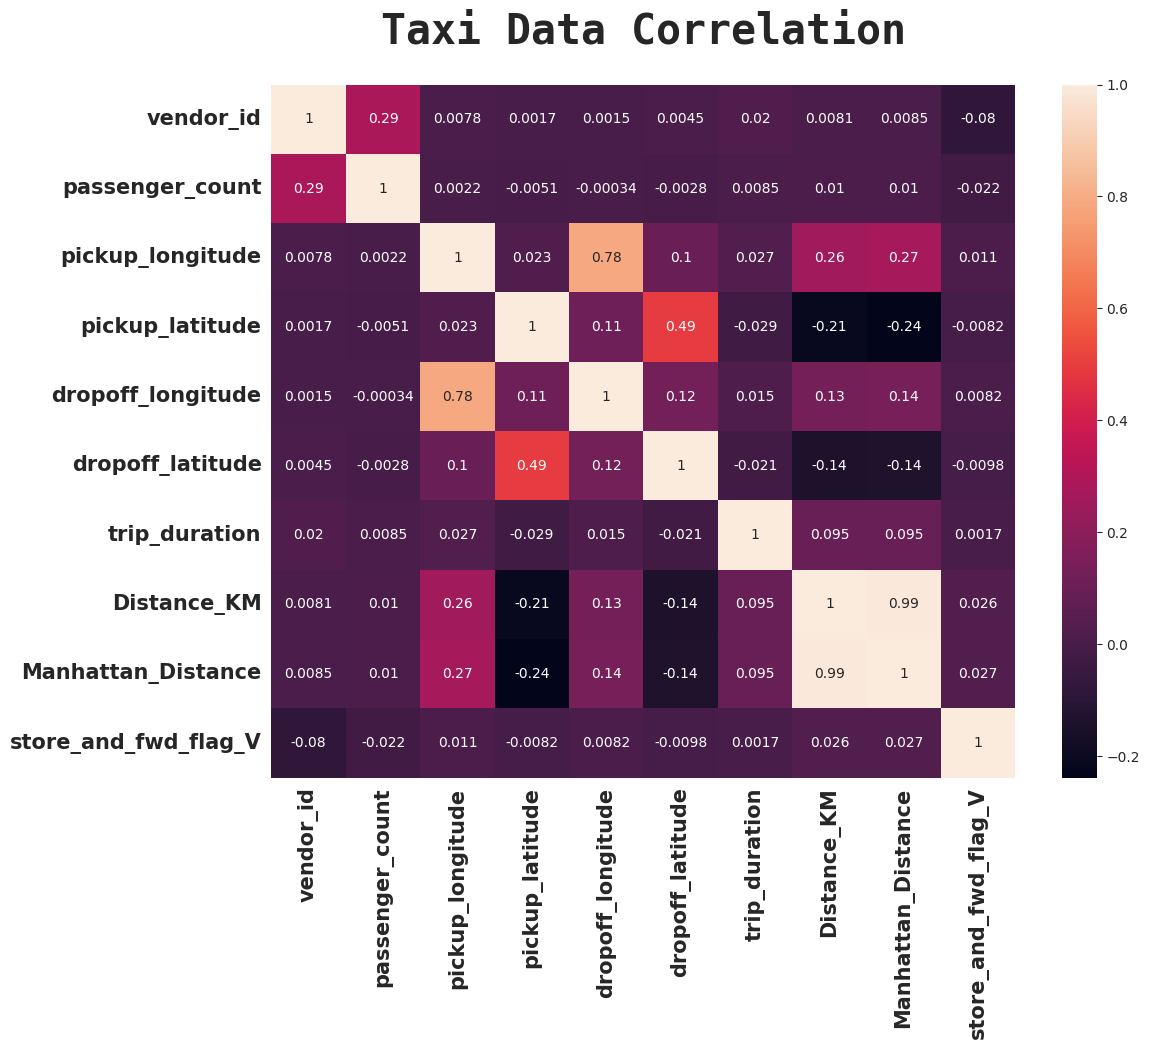

In [16]:
#check for correlation between numeric columns
numeric_columns = DF_file.select_dtypes(include=['float64', 'int64']).columns
sns.set_style("whitegrid") # set the seaborn style
plt.figure(figsize=(12, 9)) # figure the size
sns.heatmap(DF_file[numeric_columns].corr(), annot=True) # create a heatmap
plt.title("Taxi Data Correlation", weight="bold", fontsize=30, fontname="monospace", pad=30) # title
plt.xticks(weight="bold", fontsize=15) # x-ticks
plt.yticks(weight="bold", fontsize=15); # y-ticks

In [17]:
# show the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False).to_frame().T) # transpose

,trip_duration,Distance_KM,Manhattan_Distance,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094777,0.094738,0.026542,0.020304,0.014678,0.008471,0.001724,-0.020677,-0.029204


We have calculted calculated the Pearson correlation coefficients between various features and the target variable(trip_duration).The value ranges from −1 to +1:

+1.0: Perfect positive linear relationship (as one increases, the other increases).

0.0: No linear relationship.

−1.0: Perfect negative linear relationship (as one increases, the other decreases).



There is almost no correlation or weak correlation between trip_duration and other attributes. Except for the 'Distance_KM' attribute, the other attributes have non linear relation with the trip duration. This means we need powerful non-linear models to capture the remaining relations.

# **Data cleaning**

Drop unnecessary columns

In [18]:
# unrelated column to the purpose of the project
DF_file.drop(['id'], axis=1, inplace=True)

In [19]:
num= DF_file[DF_file['Distance_KM']<=0]


In [20]:
print(f'{num.shape[0]} rows with problems in their distances. origion = destination')

5897 rows with problems in their distances. origion = destination


In [21]:
# check duplicated rows
DF_file.duplicated().sum()

np.int64(7)

***droping duplicates***

In [22]:
DF_file.drop_duplicates(inplace=True)

In [23]:
# identify the unique values for each column
unique_counts = DF_file.nunique()
print (unique_counts)

vendor_id                     2
pickup_datetime         1380222
dropoff_datetime        1380377
passenger_count              10
pickup_longitude          23047
pickup_latitude           45245
dropoff_longitude         33821
dropoff_latitude          62519
trip_duration              7417
Distance_KM             1452288
Manhattan_Distance       304731
store_and_fwd_flag_V          2
dtype: int64


# **Feature engineering**

convert row data to valid formats for later application

In [24]:
# Geographical Feature Engineering (K-Means Clustering)
N_CLUSTERS = 8 # A good starting point for NYC (roughly aligns with major zones in the city)

# Prepare the combined coordinate data for clustering
pickup_coords = DF_file[['pickup_longitude', 'pickup_latitude']].values
dropoff_coords = DF_file[['dropoff_longitude', 'dropoff_latitude']].values
all_coords = np.vstack([pickup_coords, dropoff_coords])

# B. Fit K-Means on the combined coordinates
print(f"Fitting K-Means with {N_CLUSTERS} clusters on all coordinates...")
try:
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10, verbose=0)
    kmeans.fit(all_coords)

    # C. Predict cluster labels for pickup and dropoff separately
    DF_file['pickup_cluster'] = kmeans.predict(pickup_coords).astype(str)
    DF_file['dropoff_cluster'] = kmeans.predict(dropoff_coords).astype(str)

    print(f"Successfully created 'pickup_cluster' and 'dropoff_cluster' features.")
    print(f"New Pickup Clusters created: {DF_file['pickup_cluster'].unique()}")

except Exception as e:
    print(f"K-Means Clustering failed: {e}")
    # Proceed without clustering features if it fails
    pass

Fitting K-Means with 8 clusters on all coordinates...
Successfully created 'pickup_cluster' and 'dropoff_cluster' features.
New Pickup Clusters created: ['3' '0' '4' '2' '7' '6' '5' '1']


**identify weekends and weekdays**

In [25]:
# --- 'pickup_datetime' is a proper datetime object ---
DF_file['pickup_datetime'] = pd.to_datetime(DF_file['pickup_datetime'])
# Create 'day_of_week' (Numerical) ---
# Monday=0, Tuesday=1, ..., Sunday=6.
DF_file['day_of_week'] = DF_file['pickup_datetime'].dt.dayofweek

# Create 'is_weekend' (Binary Flag) ---
# We define weekend as Saturday (5) or Sunday (6).
print("Creating 'is_weekend' (1=Weekend, 0=Weekday)...")
DF_file['is_weekend'] = DF_file['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


Creating 'is_weekend' (1=Weekend, 0=Weekday)...


In [26]:

# Temporal Feature Engineering
# This range should cover the typical NYC taxi dataset period.
us_holidays = holidays.US(years=[2015, 2016, 2017])

# Convert pickup_datetime to datetime objects if it's not already
if not pd.api.types.is_datetime64_any_dtype(DF_file['pickup_datetime']):
    DF_file['pickup_datetime'] = pd.to_datetime(DF_file['pickup_datetime'])

# Feature A: Hour of Day (0-23) - CRITICAL FOR TRAFFIC PATTERNS
DF_file['pickup_hour'] = DF_file['pickup_datetime'].dt.hour
print(f"Created 'pickup_hour' feature. Unique hours: {DF_file['pickup_hour'].unique()}")

# Feature B: Time of Day Category (Categorical/Ordinal)
def get_time_category(hour):
    if 6 <= hour < 10:
        return 'Morning_Rush' # 6 AM to 9:59 AM
    elif 10 <= hour < 15:
        return 'Midday'       # 10 AM to 2:59 PM
    elif 15 <= hour < 20:
        return 'Evening_Rush' # 3 PM to 7:59 PM
    elif 20 <= hour < 23:
        return 'Evening'      # 8 PM to 10:59 PM
    else: # 23, 0, 1, 2, 3, 4, 5
        return 'Night'

DF_file['time_of_day_category'] = DF_file['pickup_hour'].apply(get_time_category)
# Check if the date falls on a US Public Holiday (1=True, 0=False)
DF_file['is_holiday'] = DF_file['pickup_datetime'].dt.normalize().apply(lambda date: 1 if date in us_holidays else 0)

print(f"Created 'time_of_day_category' and is_holiday. Unique categories: {DF_file['time_of_day_category'].unique()}")



Created 'pickup_hour' feature. Unique hours: [17  0 11 19 13 22  7 23 21  9 20 15  8  2 12  3 10 14 16  1 18  6  5  4]
Created 'time_of_day_category' and is_holiday. Unique categories: ['Evening_Rush' 'Night' 'Midday' 'Evening' 'Morning_Rush']


In [27]:
DF_file.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,1.805507,0.026478,0,3,0,6,1,0,Night,0


**Change datatime formats to seperate columns**

In [28]:
object_columns =DF_file.select_dtypes(include=['object']).columns
for col in object_columns:
    print(f'{col}: {DF_file[col].nunique()}')
    print(f'{col}: {DF_file[col].unique()}', end='\n\n')

dropoff_datetime: 1380377
dropoff_datetime: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48' ...
 '2016-04-22 07:10:25' '2016-01-05 16:02:39' '2016-04-05 14:47:43']

pickup_cluster: 8
pickup_cluster: ['3' '0' '4' '2' '7' '6' '5' '1']

dropoff_cluster: 8
dropoff_cluster: ['4' '0' '3' '2' '7' '6' '5' '1']

time_of_day_category: 5
time_of_day_category: ['Evening_Rush' 'Night' 'Midday' 'Evening' 'Morning_Rush']



In [29]:
# Extract start hour, day, and month
DF_file['pickup_hour'] = pd.to_datetime(DF_file['pickup_datetime']).dt.hour
DF_file['pickup_day'] = pd.to_datetime(DF_file['pickup_datetime']).dt.day
DF_file['pickup_month'] = pd.to_datetime(DF_file['pickup_datetime']).dt.month
DF_file.drop('pickup_datetime', axis=1, inplace=True)

DF_file.drop('dropoff_datetime', axis=1, inplace=True)


checking correlation again for only relevant attribnutes

In [30]:
# Let's see the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,trip_duration,Distance_KM,Manhattan_Distance,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094791,0.094751,0.026547,0.020296,0.014682,0.008452,0.001725,-0.020673,-0.029201


# Data visualization and handling errors/outliars

In [31]:

DF_file['passenger_count'].value_counts()

,count
passenger_count,
1,1033539
2,210315
5,78088
3,59895
6,48333
4,28402
0,60
7,3
9,1


drop rows with no passenger count attribute

In [32]:
DF_file = DF_file[DF_file['passenger_count'] != 0]

In [33]:
DF_file['store_and_fwd_flag_V'].value_counts()

,count
store_and_fwd_flag_V,
0,1450535
1,8042


In [34]:
DF_file['trip_duration'].value_counts()

,count
trip_duration,
368,1624
408,1584
348,1582
367,1581
358,1577
...,...
85002,1
81146,1
84575,1


In [35]:
DF_file[DF_file['trip_duration']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month


In [36]:
DF_file['Distance_KM'].value_counts()

,count
Distance_KM,
0.000000,5888
0.000424,101
0.000424,52
0.000424,48
0.000848,37
...,...
1.795028,1
8.261528,1
1.388063,1


In [37]:
DF_file[DF_file['Distance_KM']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
246,2,1,-73.981819,40.768963,-73.981819,40.768963,227,0.0,0.0,0,3,3,0,0,18,Evening_Rush,0,29,2
291,2,2,-73.959068,40.775661,-73.959068,40.775661,1109,0.0,0.0,0,4,4,1,0,18,Evening_Rush,0,10,5
407,2,6,-73.808487,40.687336,-73.808487,40.687336,947,0.0,0.0,0,2,2,0,0,23,Night,0,16,5
702,1,1,-73.786720,40.647041,-73.786720,40.647041,580,0.0,0.0,0,2,2,0,0,19,Evening_Rush,0,25,1
1620,1,1,-74.209854,40.816853,-74.209854,40.816853,27,0.0,0.0,0,0,0,2,0,22,Evening,0,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,2,1,-73.978859,40.756721,-73.978859,40.756721,1284,0.0,0.0,0,3,3,2,0,8,Morning_Rush,0,17,2
1456627,2,1,-73.963554,40.768517,-73.963554,40.768517,127,0.0,0.0,0,4,4,5,1,22,Evening,0,6,2
1456989,2,1,-73.984848,40.728222,-73.984848,40.728222,566,0.0,0.0,0,0,0,5,1,7,Morning_Rush,0,12,3
1457114,2,1,-73.965981,40.770988,-73.965981,40.770988,632,0.0,0.0,0,4,4,5,1,20,Evening,0,9,4


In [38]:
DF_file[DF_file['trip_duration']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month


In [39]:
DF_file = DF_file[DF_file['Distance_KM'] != 0]
DF_file.shape

(1452689, 19)

removed non zero distances

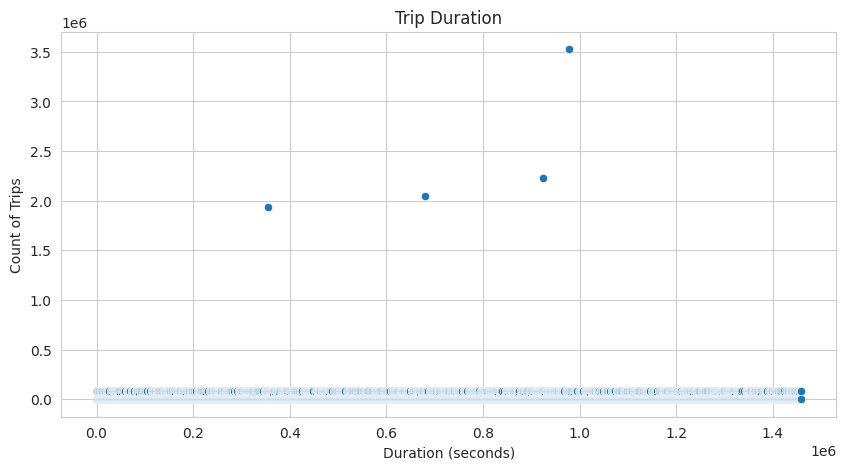

In [40]:
# Scatter for trip duration
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['trip_duration'])
plt.title("Trip Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.show()
# results shows a signficant outliars that hinders the analysis which results in extremely high durations skew the visualization.


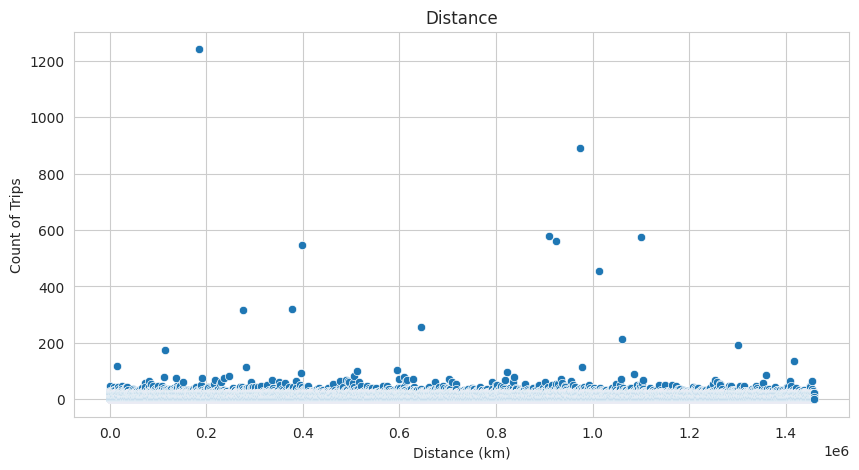

In [41]:
# Scatter for Distance
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['Distance_KM'])
plt.title("Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Count of Trips")
plt.show()
# similar is shown for the distance

Cap duration: 3442.0 in seconds 
Cap distance: 24.795344966629102 in km
(1437125, 19)


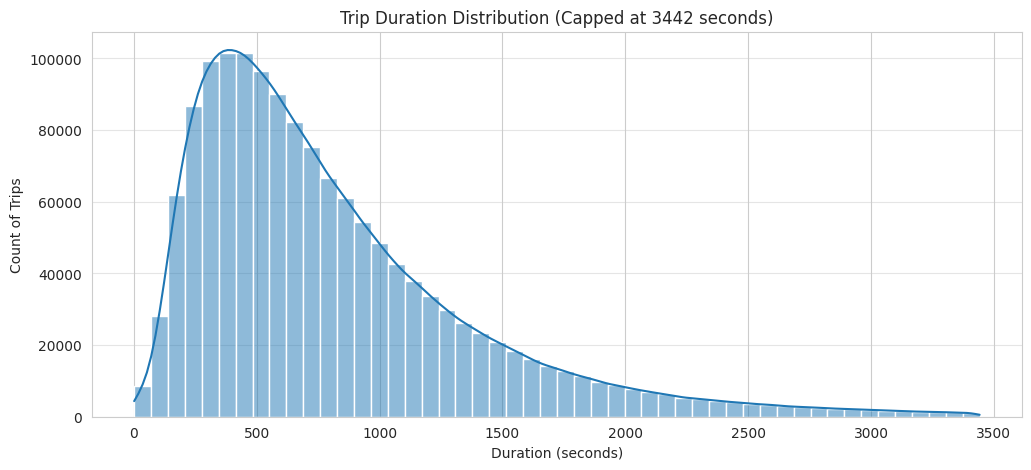

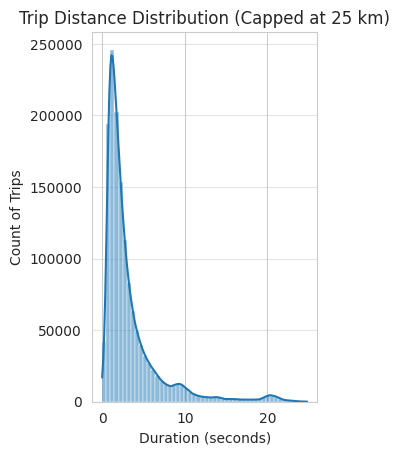

In [42]:
#avoid the outliars in both trip time and distance
# we select all datra with values below the 99th percentile for duration and 99.9th for distance


cap_duration = DF_file['trip_duration'].quantile(0.99)
cap_distance = DF_file['Distance_KM'].quantile(0.999)
print (f'Cap duration: {cap_duration} in seconds \nCap distance: {cap_distance} in km')

# Filter the data to remove extreme outliers for better visualization
df_filtered = DF_file[DF_file['trip_duration'] <= cap_duration]
# Filter the data to remove extreme outliers for better visualization
df_filtered = df_filtered[df_filtered['Distance_KM'] <= cap_distance]

print(df_filtered.shape)
'''


df_filtered = DF_file[DF_file['Distance_KM'] < 100]
df_filtered = df_filtered[df_filtered['trip_duration'] < 10000]
'''


# Use a Histogram to visualize the distribution for trip duration
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
sns.histplot(data=df_filtered, x='trip_duration', bins=50, kde=True)
plt.title(f"Trip Duration Distribution (Capped at {cap_duration:.0f} seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()



# Use a Histogram to visualize the distribution for trip ditsnace
plt.subplot(1, 2, 2)
sns.histplot(data=df_filtered, x='Distance_KM', bins=50, kde=True)
plt.title(f"Trip Distance Distribution (Capped at {cap_distance:.0f} km)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()

In [43]:
#df_filtered

Remove data outside NY city (Outliers)

In [44]:

# Define NYC Bounding Box and Filter Outliers
NYC_BOUNDS = {
    'min_lat': 40.5, 'max_lat': 40.9,
    'min_lon': -74.25, 'max_lon': -73.70
}
# filter points only inside NY city
df_filtered = df_filtered[
(df_filtered['pickup_latitude'] >= NYC_BOUNDS['min_lat']) &
(df_filtered['pickup_latitude'] <= NYC_BOUNDS['max_lat']) &
(df_filtered['pickup_longitude'] >= NYC_BOUNDS['min_lon']) &
(df_filtered['pickup_longitude'] <= NYC_BOUNDS['max_lon'])
]



Only for viosualization
show the location of the pickup points after cleaning

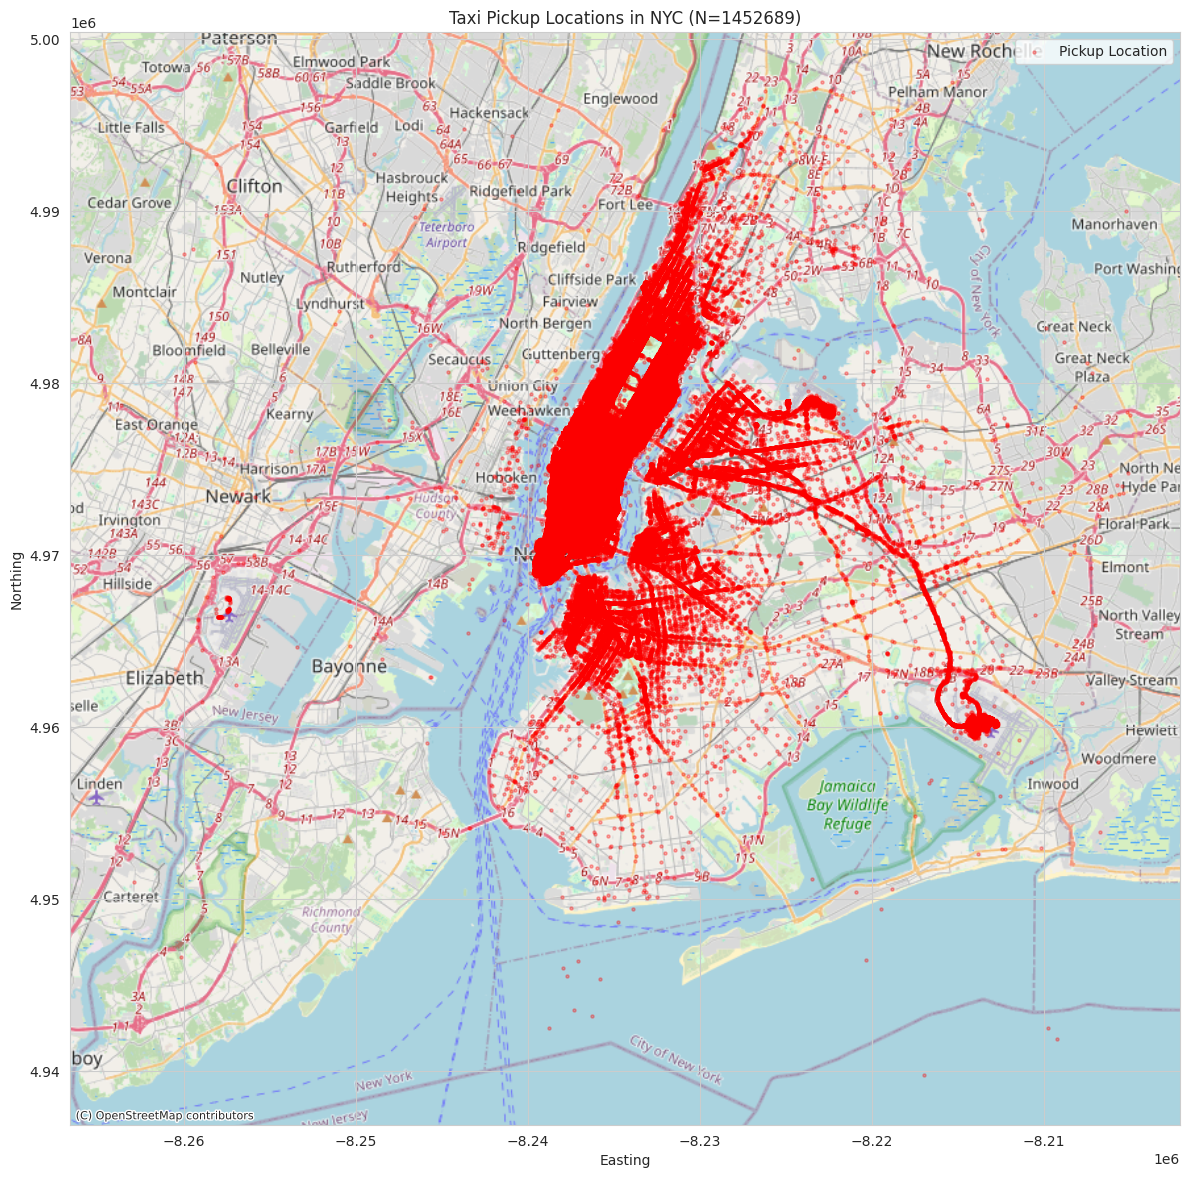

In [45]:
# update GeoDF
geometry = [Point(xy) for xy in zip(df_filtered['pickup_longitude'], df_filtered['pickup_latitude'])]
gdf = gpd.GeoDataFrame(df_filtered.copy(), geometry=geometry, crs='EPSG:4326')


# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
#remove the unrequired attributres
df_filtered.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
df_filtered.head(2)



,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
0,2,1,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0,14,3
1,1,1,663,1.805507,0.026478,0,3,0,6,1,0,Night,0,12,6


In [47]:
#removed rows
current_rows, current_cols = df_filtered.shape
print(f'Removed rows =  {init_rows- current_rows}\nwhich is about {round((init_rows- current_rows)/init_rows*100,2)}%')

Removed rows =  21700
which is about 1.49%


**Data is saved and exported for later steps**

In [48]:
df_filtered.to_csv('df_filtered.csv', index=False)

In [49]:
df_filtered.head(2)

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
0,2,1,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0,14,3
1,1,1,663,1.805507,0.026478,0,3,0,6,1,0,Night,0,12,6


# **Summary**

**Is the data complete?**  
No, the raw dataset contains rows with missing values (nulls), but we handled them.Moreover, they number is relatively low.  
**Are there extreme values (Outliers)?**  
Yes, it is highly likely for trip_duration (e.g., 1-second trips or trips lasting several days), dsitances of 0 KM or very long trips, and geographical coordinates (e.g., coordinates outside the NYC area).  
**Action**: Necessary data filtering were applied to exclude physically impossible or irrelevant trips due to their irrelevent valus.